In [18]:
import os
import faiss
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from datasets import load_dataset

General Information of the Vector DB

In [19]:
dataset = load_dataset("ed-donner/pricer-data")
train = dataset["train"]

# List all feature columns
print("Available feature columns:", train.column_names)

# You can also inspect schema (data types)
print("\nSchema / Features:")
print(train.features)

Available feature columns: ['text', 'price']

Schema / Features:
{'text': Value('string'), 'price': Value('float64')}


In [2]:
# Path where your index is saved
save_path = "/home/lisa/Arupreza/ShopAI/product_vector_store"
embedding_model = "nomic-ai/nomic-embed-text-v1"

In [3]:
# Reload embeddings
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model,
    model_kwargs={"device": "cuda", "trust_remote_code": True},
    encode_kwargs={"normalize_embeddings": True}
)

<All keys matched successfully>


In [4]:
# Reload vectorstore
vectorstore = FAISS.load_local(save_path, embeddings, allow_dangerous_deserialization=True)

In [25]:
# Get underlying FAISS index
faiss_index = vectorstore.index

# Number of vectors stored
ntotal = faiss_index.ntotal

# Dimensionality of vectors
dim = faiss_index.d

print(f"✅ Vector store loaded from {save_path}")
print(f"Number of vectors stored: {ntotal}")
print(f"Dimensionality of each vector: {dim}")

✅ Vector store loaded from /home/lisa/Arupreza/ShopAI/product_vector_store
Number of vectors stored: 400000
Dimensionality of each vector: 768


In [26]:
vec = faiss_index.reconstruct(0)

print(f"Vector ID: {0}")
print("Vector shape:", len(vec))
print("First 10 values:", vec)

print("\n")

doc_id = vectorstore.index_to_docstore_id[0]
doc = vectorstore.docstore.search(doc_id)

print("Document text snippet:", doc.page_content[:200])
print("Metadata:", doc.metadata)

Vector ID: 0
Vector shape: 768
First 10 values: [-6.01520482e-03  1.71472970e-02 -9.67026968e-03 -5.17558120e-02
  4.77842763e-02 -2.69817971e-02  3.24559747e-03  3.45099866e-02
 -1.52182113e-02  1.36211887e-02  1.88076049e-02  6.95003346e-02
 -3.67469788e-02  1.62119698e-02  5.85526079e-02 -1.52228335e-02
 -8.70686956e-03 -5.02367653e-02  1.69482306e-02 -9.85203893e-04
  3.62854707e-03 -4.50680591e-02 -7.61995018e-02 -3.22946608e-02
  6.99041709e-02 -1.72557607e-02  1.56553593e-02  2.56334413e-02
 -4.34625335e-02  4.60213423e-03  1.56652313e-02 -3.70049067e-02
 -1.54911969e-02 -7.11694434e-02 -7.55840987e-02 -3.35195884e-02
  2.47931667e-02  3.22754271e-02  3.84912193e-02  3.67500149e-02
  4.20586430e-02 -2.15019402e-03  2.99205091e-02 -5.50386980e-02
  2.41330545e-02 -7.17599783e-03  1.43694994e-03 -4.71985228e-02
  4.80931476e-02  1.61331799e-02 -2.55427957e-02  6.59336597e-02
 -8.89813341e-03 -3.84793095e-02 -5.84406294e-02 -4.51466208e-03
  1.23233944e-02  2.74897404e-02 -1.940372

Vector Visualization

<All keys matched successfully>


✅ Vector store loaded with 400000 vectors


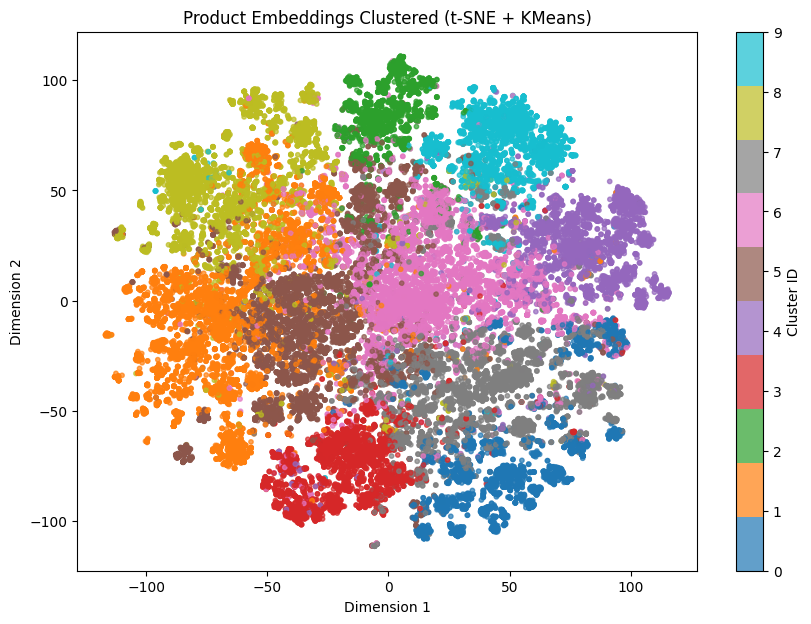

In [27]:
import os
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# -------------------
# 1. Reload FAISS vector store
# -------------------
save_path = "/home/lisa/Arupreza/ShopAI/product_vector_store"
embedding_model = "nomic-ai/nomic-embed-text-v1"

embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model,
    model_kwargs={"device": "cuda", "trust_remote_code": True},
    encode_kwargs={"normalize_embeddings": True}
)

vectorstore = FAISS.load_local(save_path, embeddings, allow_dangerous_deserialization=True)
faiss_index = vectorstore.index

print("✅ Vector store loaded with", faiss_index.ntotal, "vectors")

# -------------------
# 2. Extract vectors (sample for visualization)
# -------------------
n_samples = 50000
vectors = faiss_index.reconstruct_n(0, min(n_samples, faiss_index.ntotal))

# -------------------
# 3. KMeans clustering
# -------------------
n_clusters = 10  # tune this (try 10, 20, 50)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(vectors)

# -------------------
# 4. Dimensionality reduction for visualization
# -------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced = tsne.fit_transform(vectors)

# -------------------
# 5. Plot clusters
# -------------------
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Product Embeddings Clustered (t-SNE + KMeans)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Find Similer Products

In [1]:
import os, re, json
import json5
from typing import List
from pydantic import BaseModel
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# -------------------
# 1. Schema
# -------------------
class ProductInfo(BaseModel):
    product: str
    price: float

class ProductList(BaseModel):
    items: List[ProductInfo]

parser = PydanticOutputParser(pydantic_object=ProductList)

# -------------------
# 2. Prompt
# -------------------
prompt = PromptTemplate(
    template="""Extract all product names and their prices from the context below. 

⚠️ Rules:
- Only output a JSON object.
- JSON must have one key "items".
- "items" must be an array of {{ "product": string, "price": number }}.
- Do not include schema, explanation, or extra text.

Context:
{context}

Question: {question}

{format_instructions}
""",
    input_variables=["context", "question"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# -------------------
# 3. Load vectorstore
# -------------------
save_path = "/home/lisa/Arupreza/ShopAI/product_vector_store"

embeddings = HuggingFaceEmbeddings(
    model_name="nomic-ai/nomic-embed-text-v1",
    model_kwargs={"device": "cuda", "trust_remote_code": True},
    encode_kwargs={"normalize_embeddings": True}
)

vectorstore = FAISS.load_local(save_path, embeddings, allow_dangerous_deserialization=True)

# -------------------
# 4. Load fine-tuned model
# -------------------
model_path = "/home/lisa/Arupreza/ShopAI/price_prediction_peft/price_llama_lora/checkpoint-20000"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    return_full_text=False,   # don't echo the full prompt
)
llm = HuggingFacePipeline(pipeline=pipe)

# -------------------
# 5. JSON cleaning helpers
# -------------------
def clean_output(text: str) -> str:
    """Extract JSON-ish content and fix common issues."""
    matches = re.findall(r"\{[\s\S]*\}", text)
    if not matches:
        raise ValueError("❌ No JSON found in output")
    candidate = matches[-1].strip()

    # Replace single with double quotes
    candidate = candidate.replace("'", '"')

    # Ensure keys are quoted
    candidate = re.sub(r'(\b\w+\b):', r'"\1":', candidate)

    return candidate

def safe_json_parse(text: str):
    try:
        return json.loads(text)  # strict
    except Exception as e1:
        print("⚠️ Standard JSON failed:", e1)
        try:
            repaired = clean_output(text)
            return json.loads(repaired)
        except Exception as e2:
            print("⚠️ Repaired JSON still failed:", e2)
            # final fallback: json5 (tolerates missing commas, comments, trailing commas)
            return json5.loads(repaired)

# -------------------
# 6. Ask function
# -------------------
def ask(query: str, top_k: int = 3):
    docs = vectorstore.similarity_search(query, k=top_k)
    all_context = "\n\n".join([d.page_content for d in docs])

    final_prompt = prompt.format(context=all_context, question=query)
    output = llm(final_prompt)

    # HuggingFacePipeline returns list of dicts
    if isinstance(output, list) and "generated_text" in output[0]:
        output_text = output[0]["generated_text"]
    else:
        output_text = str(output)

    # First try structured parser
    try:
        return parser.parse(output_text)
    except Exception:
        print("⚠️ Raw output (before cleaning):\n", output_text)
        parsed = safe_json_parse(output_text)
        return ProductList.model_validate(parsed)

<All keys matched successfully>


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [2]:
# -------------------
# 7. Run Example
# -------------------
if __name__ == "__main__":
    query = "Find for me a gaming computer and give the price list?"
    results = ask(query, top_k=10)

    print("\n✅ Structured Results:")
    for item in results.items:
        print(item.model_dump())

/tmp/ipykernel_1580079/1558516727.py:115: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  output = llm(final_prompt)


⚠️ Raw output (before cleaning):
 Here is the output JSON:
```
{"items": [{"product": "shinobee Ryzen7 4700G Gaming Computer, 4.40 GHz, 16 GB DDR4, AMD Radeon 8-Core Graphics 4GB, 512 GB SSD, USB 3, Win 11 Prof #6923", "price": 500.00}, {"product": "STGAubron Gaming Black Desktop PC Computer,Intel Core I7 up to 3.9 GHz,GeForce GTX 1660Ti 6G SSD,WiFi,BT Keyboard&Mouse,RGB Mouse Pad,RGB BT Sound", "price": 600.00}, {"product": "Gaming PC Desktop, Intel Core i7, TechMagnet Siwa 3, GT 1030 4GB DDR4, 16GB RAM, 1TB SSD + 2TB HDD, New MTG 22 Inch Monitor, MTG Gaming Kit with MTG Webcam, WiFi, Windows 10 Pro (Renewed)", "price": 500.00}, {"product": "Computer Desktop PC MTG Aurora - Intel Core i7 4th Gen, 16GB Ram DDR4, 512GB Nvme, MTG Dual 24 Inch Monitor, MTG Wireless Ergonomic Keyboard Mouse, RGB Headphone, Webcam, Win 10 Home", "price": 697.00}, {"product": "Computer Desktop PC MTG Aurora - Intel Core i7 4th Gen, 16GB Ram DDR4, 1TB Nvme, MTG Dual 24 Inch Monitor, MTG Wireless Keyboard Mous

ValueError: <string>:1 Unexpected end of input at column 1393